# Basic Dataset demo

## Imports

In [26]:
import os
import torch
from data.data_handler import (
    read_in_data,
    create_simple_encoder_decoder,
    tensor_to_string,
)
from data.dummy_file_generators import save_data_as_txt
from my_models.bigram import BigramModel
import matplotlib.pyplot as plt

# Load dummy dataset

In [27]:
# First we read in the data
char_dict, data = read_in_data("data/basic_data/basic_data_1000.txt")

Corpus has 5 unique letter(s), 0 unique numbers(s) and 2 unique punctuation(s)
Corpus has 7 unique characters.


Characters are 'abcde\n '

Rule 1 whenever c is chosen, the next character must be d or b
Rule 2 whenever e is chosen, the next character must be a new line
Rule 3 whenever a is chosen, the next character cannot be a new line
Rule 4 first character in a line cannot be new line or space

# Create Encoder/Decoder

In [28]:
# Create the encoder and decoder dictionaries and the encode and decode functions
encoder_dict, decoder_dict, encode, decode = create_simple_encoder_decoder(char_dict)

# Train, Validation, Test Split

In [29]:
# Create training data/test split
if not os.path.exists("data/basic_data/train_data.txt"):
    # Load the data into torch tensor
    data = torch.tensor(encode(data), dtype=torch.long)
    # Apply the decode function to the data when converted to a list
    decoded_data = decode(data.tolist())

    train_data = data[: int(len(data) * 0.7)]
    val_data = data[int(len(data) * 0.7) : int(len(data) * 0.9)]
    test_data = data[int(len(data) * 0.9) :]

    # Create the train data if the saved file doesn't already exist

    # Create an 70, 20, 10 train, validation, test split
    train_data_str = tensor_to_string(train_data, decode)
    val_data_str = tensor_to_string(val_data, decode)
    test_data_str = tensor_to_string(test_data, decode)

    # Save the data as a text file
    save_data_as_txt(train_data_str, "data/basic_data/decoded_train_data.txt")
    save_data_as_txt(val_data_str, "data/basic_data/decoded_val_data.txt")
    save_data_as_txt(test_data_str, "data/basic_data/decoded_test_data.txt")

else:
    # Read in the data
    with open("databasic_data/decoded_train_data.txt", "r") as f:
        train_data = f.read()
    with open("data/basic_data/decoded_val_data.txt", "r") as f:
        val_data = f.read()
    with open("data/basic_data/decoded_test_data.txt", "r") as f:
        test_data = f.read()

    # Load the data into torch tensor
    train_data = torch.tensor(encode(train_data), dtype=torch.long)
    val_data = torch.tensor(encode(val_data), dtype=torch.long)
    test_data = torch.tensor(encode(test_data), dtype=torch.long)

In [30]:
block_size = 8  # Arbitrary block size
x = train_data[:block_size]
y = train_data[1 : block_size + 1]
for t in range(block_size):
    context = x[: t + 1]
    target = y[t]
    print(
        f"when input is '{tensor_to_string(context, decode)}' ({context}), the target is:'{decode([target.tolist()])}'({target})"
    )

# print(f"when the input is {tensor_to_string(context, decode)} the target is: {decode([target.tolist()])}")

torch.manual_seed(6345789)
batch_size = 4  # how many independent sequences to process in parallel?
block_size = 8  # what is the maximum context length for predictions?

when input is 'c' (tensor([4])), the target is:'['d']'(5)
when input is 'cd' (tensor([4, 5])), the target is:'['c']'(4)
when input is 'cdc' (tensor([4, 5, 4])), the target is:'['b']'(3)
when input is 'cdcb' (tensor([4, 5, 4, 3])), the target is:'['c']'(4)
when input is 'cdcbc' (tensor([4, 5, 4, 3, 4])), the target is:'['b']'(3)
when input is 'cdcbcb' (tensor([4, 5, 4, 3, 4, 3])), the target is:'['\n']'(0)
when input is 'cdcbcb
' (tensor([4, 5, 4, 3, 4, 3, 0])), the target is:'['c']'(4)
when input is 'cdcbcb
c' (tensor([4, 5, 4, 3, 4, 3, 0, 4])), the target is:'['b']'(3)


In [31]:
# Utility function for sampling a train, validation or test batch
def get_batch(split: str) -> torch.Tensor:
    """Get a batch of data from the train, validation or test set."""

    if split == "train":
        data = train_data
    elif split == "val":
        data = val_data
    elif split == "test":
        data = test_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    return x, y

In [32]:
xb, yb = get_batch("train")
for b in range(batch_size):  # batch dimension
    for t in range(block_size):  # time dimension
        context = xb[b, : t + 1]
        target = yb[b, t]
        # print(f"when input is {context.tolist()} the target: {target}")

In [33]:
# Initialize the model
model = BigramModel(len(encoder_dict), len(encoder_dict))
embeds, loss = model(idx=xb, target=yb)
print(embeds.shape)
print(loss)

torch.Size([32, 7])
tensor(2.5592, grad_fn=<NllLossBackward0>)


In [34]:
# Generate 100 characters
chars = decode(
    model.generate(idx=torch.zeros((1, 1), dtype=torch.long), length=100)[0].tolist()
)
# Join the characters together and then print the string
print("".join(chars))
print("---------------------------------")



ccceacb
dccccbacca
d
acc
dcccb
baaa

 e 
ccccccc
d
bbdc 
a dae ebe debaae eb
dccbabe   de da
d

ccc
---------------------------------


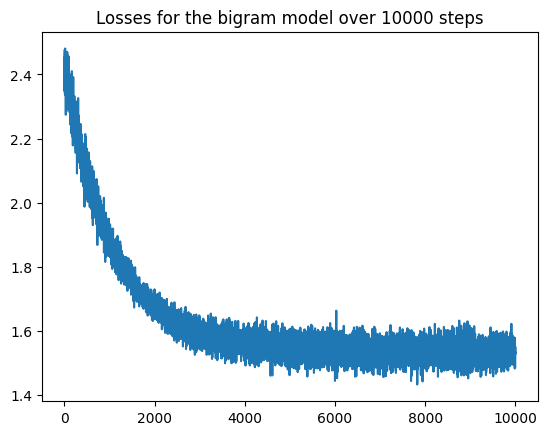

In [35]:
# Generate 100 characters
Optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
losses = []
num_steps = 10000
for steps in range(num_steps):
    # Get the batch of data
    xb, yb = get_batch("train")
    # Zero the gradients
    Optimiser.zero_grad()
    # Get the embeddings and the loss
    embeds, loss = model(idx=xb, target=yb)
    # Backpropagate the loss
    loss.backward()
    # Take a step with the optimiser
    Optimiser.step()
    # Print the loss
    losses.append(loss.item())
    # if steps % 100 == 0:
    #     print(f'Loss at step {steps}: {loss.item()}')
    #     # generate 10 characters
    #     model.eval()
    #     chars = decode(model.generate(idx=torch.zeros((1, 1), dtype=torch.long), length=10)[0].tolist())
    #     print(''.join(chars))
    #     model.train()

plt.plot(losses)
plt.title(f"Losses for the bigram model over {num_steps} steps")
plt.show()

In [36]:
# Now generate 100 characters
chars = decode(
    model.generate(idx=torch.zeros((1, 1), dtype=torch.long), length=1000)[0].tolist()
)
# Join the characters together and then print the string
print("".join(chars))
print("---------------------------------")


bacbb
ddbe
abe
d
bacdbbdb  cdcdcdabbe
b bdcddbdcbaba e
cbadbcbe
bbbcdcb cde
ba e
dcd ae
b  a ddbcde
ae
dcbd e
a d
db bdd ad  
cd dcde
e
bbadaabdcbdcdcde
cb ae
db a cb be
ade
b cbe
cb cbcbcdbbdbcbabcda 
addcde
ae
cde
badddbcdcdda cbd acdbabbadcde
bdcdcb
acb cdabbaae
cd
dbcd
b  cbe
cde
bcdcbadd
bcbacbd
d dd  ab  cbacd bbd
de
cbe
cb
bcddcba daae
cb acdcdcdcbd
cba  cb a bd dbabbcdbbcda dcdcb dbacda 
adbbaacbaaabdcbd e
cdadcbbcbe
bdba cdcb abbdcbb abb  cbb bacb bbe
cbcb
cbbe
b cbe
dcde
ba bbdcba  cd 
ddaa e
a b  e
bd  a  acd e
cdab 
b
b dade
b  e
cbacdcd e
cd d cbddd bbbe
acdcbdabe
cbe
d
acda   e
dabcbb
bacd de
b dd ae
dbbcdabcbcde
ab
dcd bbe
b
cbbbcbbcd bcdae
cbb  bbbcde
ab b
ade
ab
ddd
b
ddbb bddaa bb
ae
bcbcddaaa d
baba bcd
dabe
cdddbcdcbbbcdcd e
bbdcb
ab
ab ae
cd
a d
abbdb cbbdcdcdd
cbc
cdcb e
ba b 
b ba cdbbaabe
cb e
cd cdabe
cddda cd
cbe
cbcbbadaaddbcbe
cddab cdcbbb 
adacdcbbd
cdcb abcbcd
cbaabcdcbcbcdaab b 
aab  e
cdba cbe
cb  dbbcb 
dadad bbaae
dd
aad 
dd
cb cddbbe
ba 
abd db  cd c